In [1]:
import os

import cmcrameri.cm as cmc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns



In [2]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined.csv')

In [3]:
def get_stf(scardec_name, wanted_type = 'fctopt'):
    db = combined[combined['scardec_name']==scardec_name]

    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    return momentrate, time, db

In [4]:
# looks for time value of root
def f3(end_time, total_moment, time_opt, momentrate_opt, start, points_before_zero, proportion = 0.1):
    dx = time_opt[1]-time_opt[0]
    end_window = (end_time/dx)+points_before_zero
    end = int(np.floor(end_window))
    short = scipy.integrate.simpson(momentrate_opt[start:end], dx = dx)
    return short-(total_moment*proportion)

In [6]:
def get_mag(scardec_name):
    db = combined[combined['scardec_name']==scardec_name]
    mag = db['scardec_magnitude'].values[0]
    return mag

def get_date(scardec_name):
    db = combined[combined['scardec_name']==scardec_name]
    year = db['year'].values[0]
    month = db['month'].values[0]
    day = db['day'].values[0]
    return year, month, day

In [ ]:
proportions_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

all_durations = []
all_root_times = []
all_moments = []
all_relative_root_times = []

results_db = pd.DataFrame(columns = ['scardec_name', 'magnitude', 'int_magnitude', 'year', 'month', 'day', '10', '20', '30', '40', '50', '60', '70', '80', '90'])

colors = {'10': 'dodgerblue',
          '20': 'darkorange',
          '30': 'green',
          '40': 'red',
          '50': 'purple',
          '60': 'blue',
          '70': 'orange',
          '80': 'green',
          '90': 'red'}

for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec'):
    #print(scardec_name)
    momentrate_opt, time_opt, db = get_stf(scardec_name)

    not_zero = np.where(momentrate_opt > 0)[0]

    dx = time_opt[1]-time_opt[0]

    start = min(not_zero)
    end = max(not_zero)
    points_before_zero = abs(min(time_opt)/dx)

    duration = time_opt[end] - time_opt[start]

    start_time = time_opt[start]
    end_time = time_opt[end]

    total_moment = scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0])

    relative_root_times = []
    for proportion in proportions_list:
        root, r = scipy.optimize.bisect(f3,
                                        start_time+dx,
                                        end_time,
                                        rtol = 1e-6,
                                        full_output = True,
                                        args = (total_moment,
                                                time_opt,
                                                momentrate_opt,
                                                start,
                                                points_before_zero,
                                                proportion,))

        root_idx = np.floor(root/dx)
        root_time = root_idx*dx
        relative_root_times.append((root_time-start_time)/duration)
    mags = get_mag(scardec_name)
    int_mags = int(mags)

    list_for_database = [scardec_name, mags, int_mags, *get_date(scardec_name), *relative_root_times]
    results_db.loc[len(results_db)] = list_for_database


In [8]:
results_10 = pd.DataFrame(columns = ['scardec_name', 'magnitude', 'int_magnitude', 'year' ,'month', 'day', '0_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_70', '70_80', '80_90', '90_100'])

results_10['scardec_name'] = results_db['scardec_name']
results_10['magnitude'] = results_db['magnitude']
results_10['int_magnitude'] = results_db['int_magnitude']
results_10['year'] = results_db['year']
results_10['month'] = results_db['month']
results_10['day'] = results_db['day']

results_10['0_10'] = results_db['10']
results_10['10_20'] = results_db['20'] - results_db['10']
results_10['20_30'] = results_db['30'] - results_db['20']
results_10['30_40'] = results_db['40'] - results_db['30']
results_10['40_50'] = results_db['50'] - results_db['40']
results_10['50_60'] = results_db['60'] - results_db['50']
results_10['60_70'] = results_db['70'] - results_db['60']
results_10['70_80'] = results_db['80'] - results_db['70']
results_10['80_90'] = results_db['90'] - results_db['80']
results_10['90_100'] = 1 - results_db['90']


In [14]:
len(proportions_list)

9

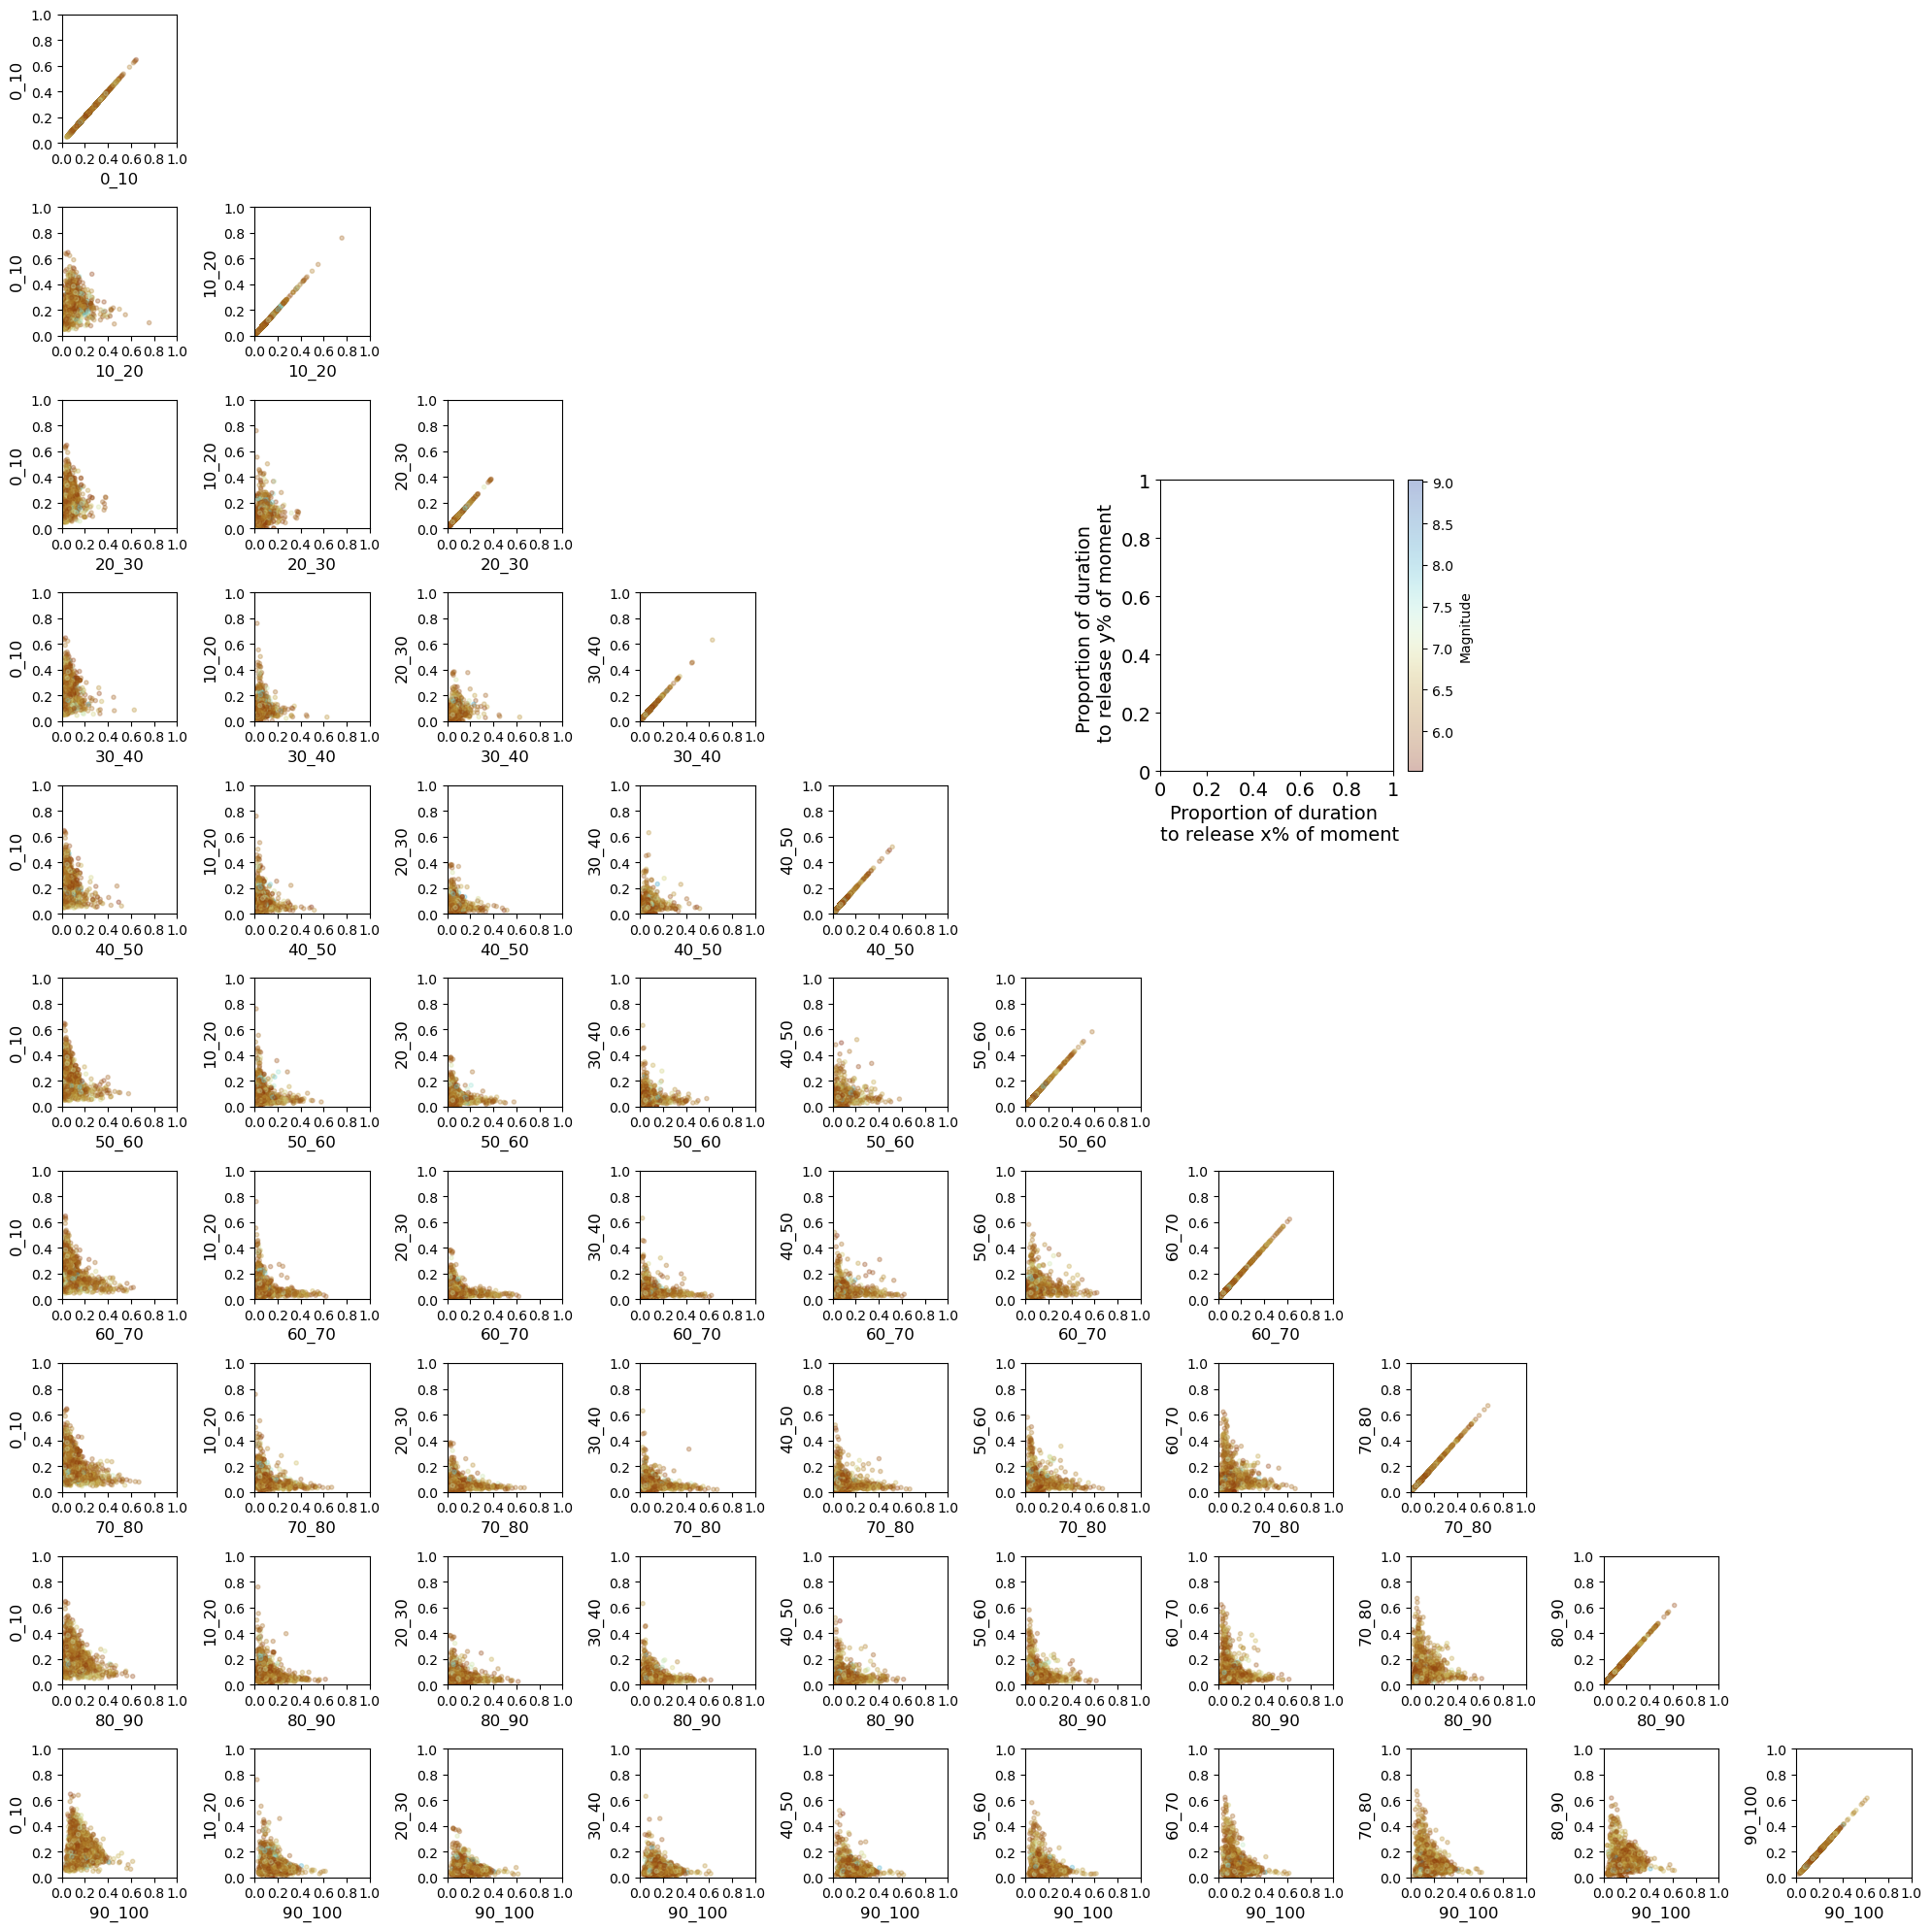

In [20]:
fig, axs = plt.subplots(len(proportions_list)+1, len(proportions_list)+1, figsize = (20,20))

proportions_list = np.array(proportions_list)
all_relative_root_times = np.array(all_relative_root_times)
all_durations = np.array(all_durations)
all_moments = np.array(all_moments)

i = 0
j = 0
for x_col in results_10.columns[6:]:
    j = 0
    for y_col in results_10.columns[6:]:
        if i >= j:
            sc = axs[i][j].scatter(results_10[x_col],
                              results_10[y_col],
                              alpha = 0.3,
                              marker = '.',
                              c = results_10['magnitude'],
                              cmap = cmc.roma)
            axs[i][j].set_xlabel(f'{x_col}', fontsize = 12)
            axs[i][j].set_ylabel(f'{y_col}', fontsize = 12)
            axs[i][j].set_xlim(0, 1)
            axs[i][j].set_ylim(0, 1)
            axs[i][j].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            axs[i][j].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        # elif i == 1 and j == len(proportions_list)-2:
        #     print(i, j)
        #     #axs[i][j].set_title('Proportion of duration to release moment')
            #print(i, j, 'on')
        else:
            #print(i, j, 'off')
            axs[i][j].axis('off')
        j += 1
    i += 1

plt.tight_layout()
left, bottom, width, height = [0.6, 0.6, 0.15, 0.15]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.set_xlabel('Proportion of duration \n to release x% of moment', fontsize = 14)
ax2.set_ylabel('Proportion of duration \n to release y% of moment', fontsize = 14)

ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1], labels = ['0', '0.2', '0.4','0.6', '0.8', '1'], fontsize = 14)
ax2.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1], labels = ['0', '0.2', '0.4','0.6', '0.8', '1'], fontsize = 14)

fig.colorbar(sc, ax = ax2, label = 'Magnitude', orientation = 'vertical')

plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/moment_intervals_comparisons/relative_times_for_10_percent_intervals.png')

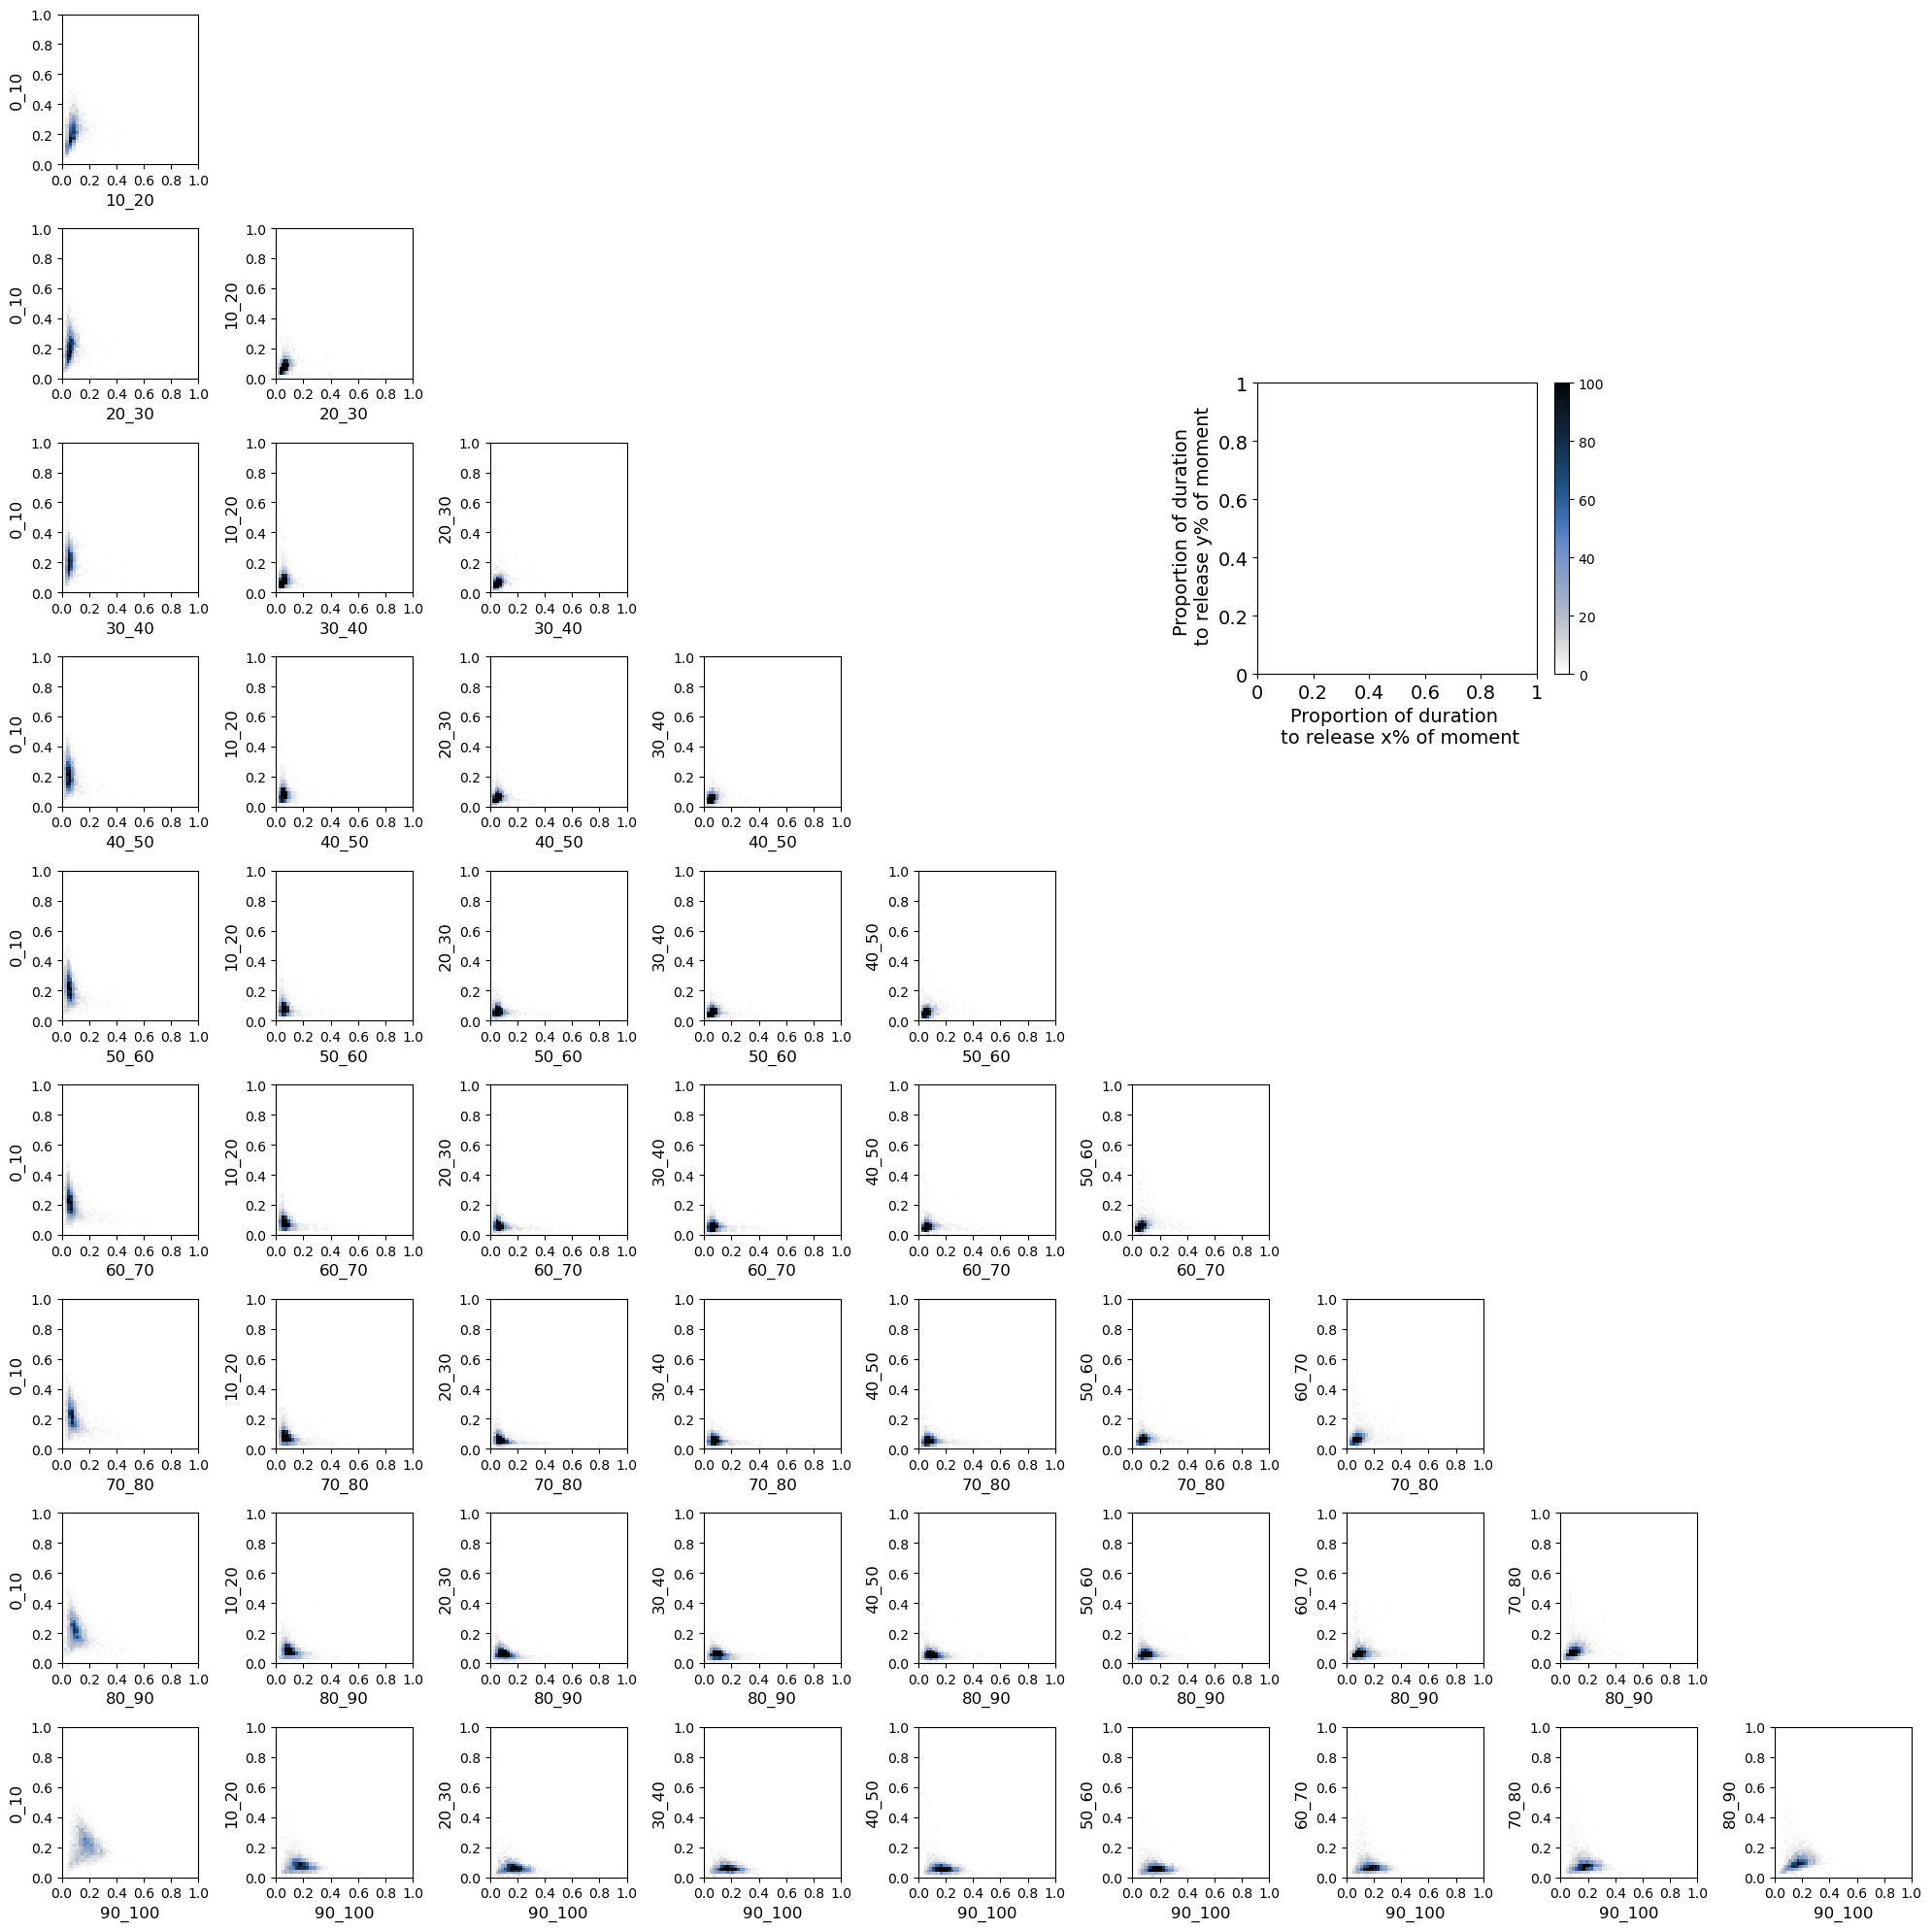

In [65]:
fig, axs = plt.subplots(len(proportions_list), len(proportions_list), figsize = (20,20))

proportions_list = np.array(proportions_list)
all_relative_root_times = np.array(all_relative_root_times)
all_durations = np.array(all_durations)

a = 1
b = 0
i = 0
j = 0
for x_col in results_10.columns[6:]:
    j = 0
    b = 0
    for y_col in results_10.columns[6:]:
        if j < len(proportions_list) and i > 0:
            #axs[i][j].set_xlabel(f'{a},{b}', fontsize = 12)
            # x_prop = proportions_list[a]
            # y_prop = proportions_list[b]
            if i != j:
                if i > j:
                    #axs[i-1][j].scatter([0.5],[0.5], color = 'red')
                    h = axs[i-1][j].hist2d(results_10[x_col],
                                    results_10[y_col],
                                    cmap = cmc.oslo_r,
                                    density=True,
                                    bins = 30,
                                    vmin = 0,
                                    vmax = 100)
                    axs[i-1][j].set_xlabel(f'{x_col}', fontsize = 12)
                    axs[i-1][j].set_ylabel(f'{y_col}', fontsize = 12)
                    #axs[i-1][j].set_xlabel(f'{i, j}', fontsize = 12)
                    axs[i-1][j].set_xlim(0, 1)
                    axs[i-1][j].set_ylim(0, 1)
                    axs[i-1][j].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
                    axs[i-1][j].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

                else:
                    axs[i-1][j].axis('off')
                    #axs[i-1][j].set_ylabel(f'off {i, j}', fontsize = 12)
                    #axs[i-1][j].scatter([0.5],[0.5], color = 'blue', marker = 'x', s = 100)
            else:
                # axs[i-1][j].set_ylabel(f'off {i, j}', fontsize = 12)
                # axs[i-1][j].scatter([0.5],[0.5], color = 'orange', marker = '^', s = 100)
                axs[i-1][j].axis('off')
        #else:
            #axs[a-1][b].scatter([0.5],[0.5], color = 'blue', marker = '^', s = 100)
            #axs[i-1][j].axis('off')
            j += 1
    i += 1


plt.tight_layout()
left, bottom, width, height = [0.65, 0.65, 0.18, 0.15]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.set_xlabel('Proportion of duration \n to release x% of moment', fontsize = 14)
ax2.set_ylabel('Proportion of duration \n to release y% of moment', fontsize = 14)

ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1], labels = ['0', '0.2', '0.4','0.6', '0.8', '1'], fontsize = 14)
ax2.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1], labels = ['0', '0.2', '0.4','0.6', '0.8', '1'], fontsize = 14)

fig.colorbar(h[3], ax = ax2)
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/moment_intervals_comparisons/intervals_relative_root_times_heatmap_no_diagonal_vmax_100.png')

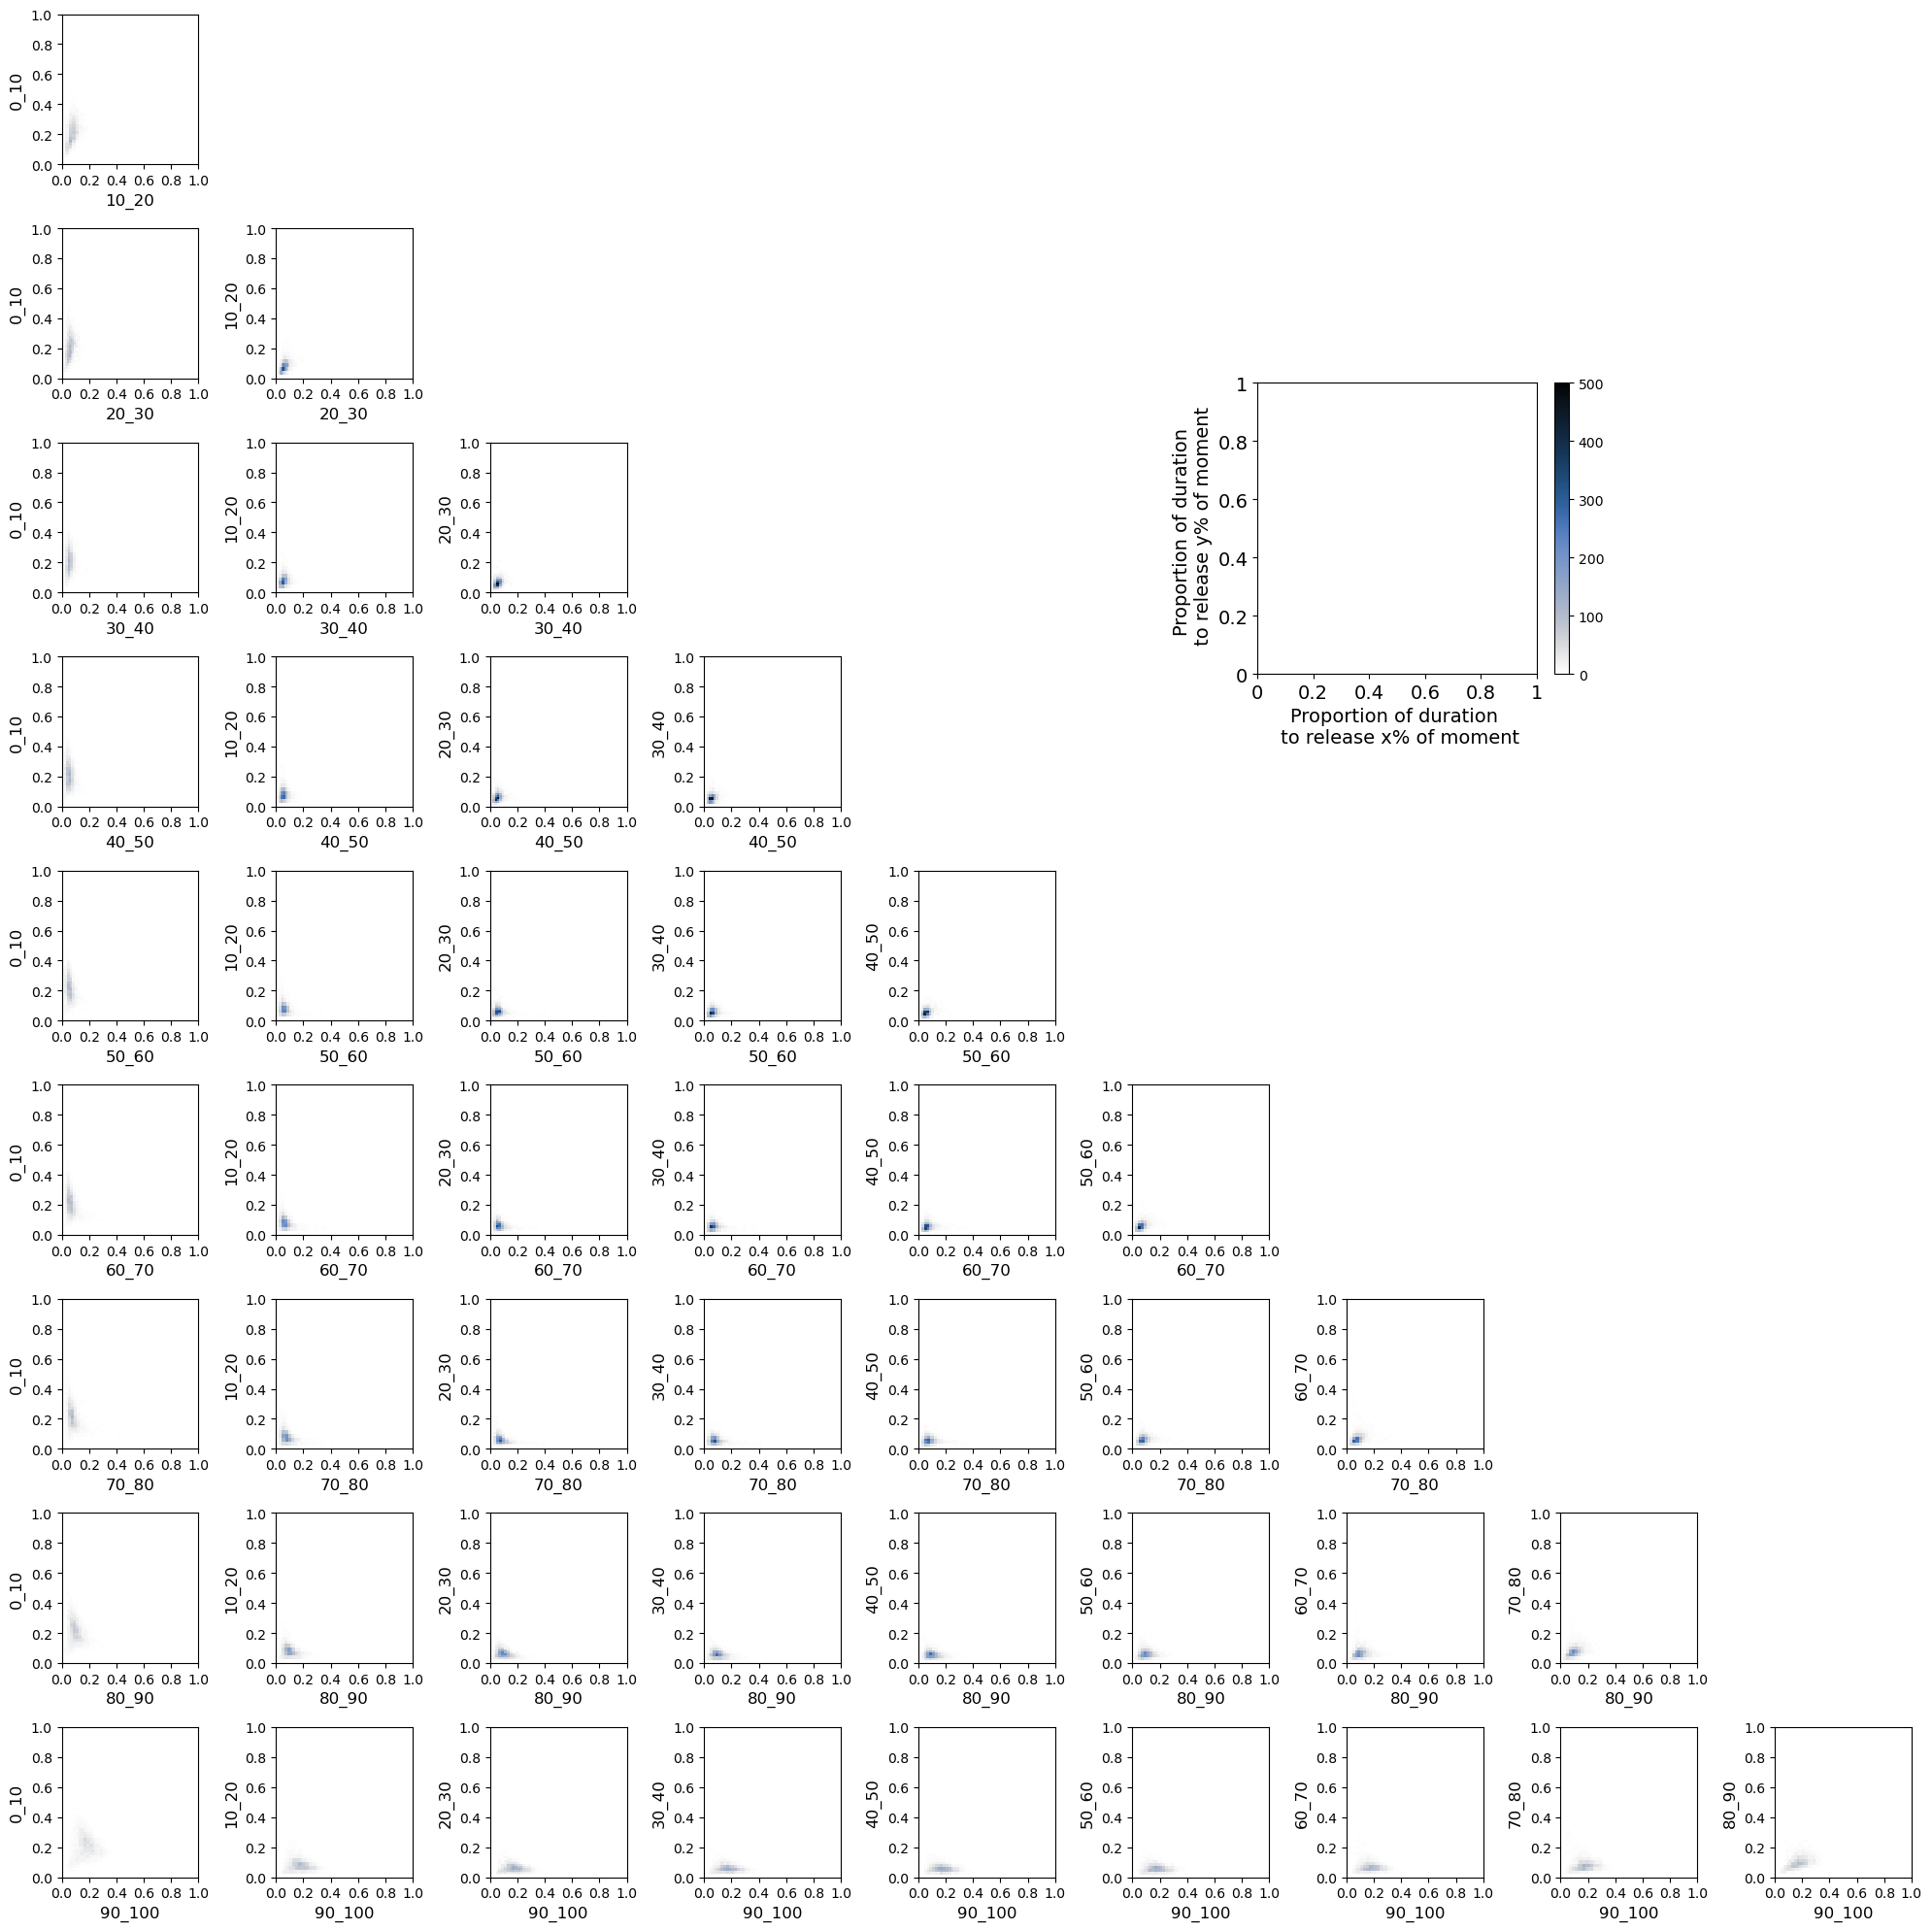

In [64]:
fig, axs = plt.subplots(len(proportions_list), len(proportions_list), figsize = (20,20))

proportions_list = np.array(proportions_list)
all_relative_root_times = np.array(all_relative_root_times)
all_durations = np.array(all_durations)

a = 1
b = 0
i = 0
j = 0
for x_col in results_10.columns[6:]:
    j = 0
    b = 0
    for y_col in results_10.columns[6:]:
        if j < len(proportions_list) and i > 0:
            #axs[i][j].set_xlabel(f'{a},{b}', fontsize = 12)
            # x_prop = proportions_list[a]
            # y_prop = proportions_list[b]
            if i != j:
                if i > j:
                    #axs[i-1][j].scatter([0.5],[0.5], color = 'red')
                    h = axs[i-1][j].hist2d(results_10[x_col],
                                    results_10[y_col],
                                    cmap = cmc.oslo_r,
                                    density=True,
                                    bins = 30,
                                    vmin = 0,
                                    vmax = 500)
                    #print(max(h[0].flatten()))
                    axs[i-1][j].set_xlabel(f'{x_col}', fontsize = 12)
                    axs[i-1][j].set_ylabel(f'{y_col}', fontsize = 12)
                    #axs[i-1][j].set_xlabel(f'{i, j}', fontsize = 12)
                    axs[i-1][j].set_xlim(0, 1)
                    axs[i-1][j].set_ylim(0, 1)
                    axs[i-1][j].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
                    axs[i-1][j].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

                else:
                    axs[i-1][j].axis('off')
                    #axs[i-1][j].set_ylabel(f'off {i, j}', fontsize = 12)
                    #axs[i-1][j].scatter([0.5],[0.5], color = 'blue', marker = 'x', s = 100)
            else:
                # axs[i-1][j].set_ylabel(f'off {i, j}', fontsize = 12)
                # axs[i-1][j].scatter([0.5],[0.5], color = 'orange', marker = '^', s = 100)
                axs[i-1][j].axis('off')
        #else:
            #axs[a-1][b].scatter([0.5],[0.5], color = 'blue', marker = '^', s = 100)
            #axs[i-1][j].axis('off')
            j += 1
    i += 1


plt.tight_layout()
left, bottom, width, height = [0.65, 0.65, 0.18, 0.15]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.set_xlabel('Proportion of duration \n to release x% of moment', fontsize = 14)
ax2.set_ylabel('Proportion of duration \n to release y% of moment', fontsize = 14)

ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1], labels = ['0', '0.2', '0.4','0.6', '0.8', '1'], fontsize = 14)
ax2.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1], labels = ['0', '0.2', '0.4','0.6', '0.8', '1'], fontsize = 14)

fig.colorbar(h[3], ax = ax2)
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/moment_intervals_comparisons/relative_root_times_heatmap_intervals_no_diagonal_vmax_500.png')